# Sparkify 项目 Workspace
这个 Workspace 包括一个迷你的子数据集（128MB），是完整数据集（12GB）的一个子集。在将你的项目部署到云上之前，你可以自由使用 Workspace 来创建你的项目或用Spark来探索这个较小数据集。设置 Spark 集群的指南可以在选修 Spark 课程的内容里找到。

你可以依照下面的步骤进行项目的数据分析和模型搭建部分。

In [1]:
# import libraries
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, avg, count
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master('local') \
    .appName('Sparkify Project') \
    .getOrCreate()

# 加载和清洗数据
在这个 Workspace 中，小数据集的名称是 `mini_sparkify_event_data.json`.加载和清洗数据集，检查是否有无效或缺失数据——例如，没有userid或sessionid的数据。 

In [3]:
sparkify_data = 'mini_sparkify_event_data.json'
data = spark.read.json(sparkify_data)

In [4]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
data.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [6]:
data.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [7]:
#数据集有多少行
data.count()

286500

In [8]:
data.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [9]:
data.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [10]:
data_valid = data.dropna(how='any', subset=['userId', 'sessionId'])

In [11]:
#把userId和sessionId列的空值删掉后数据集有多少行
data_valid.count()

286500

In [12]:
data.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [13]:
data.select('sessionId').dropDuplicates().sort('sessionId').show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [14]:
#把数据集中userId列的空字符串都删除掉
data_valid = data_valid.filter(data_valid.userId != '')

In [15]:
#把userId列的空字符串删掉后数据集有多少行
data_valid.count()

278154


# 探索性数据分析
当你使用完整数据集时，通过加载小数据集，在 Spark 中完成基础操作来实现探索性数据分析。在这个 Workspace 中，我们已经提供给你一个你可以探索的小数据集。

### 定义客户流失

在你完成初步分析之后，创建一列 `Churn` 作为模型的标签。我建议你使用 `Cancellation Confirmation` 事件来定义客户流失，该事件在付费或免费客户身上都有发生。作为一个奖励任务，你也可以深入了解 `Downgrade` 事件。

### 探索数据
你定义好客户流失后，就可以执行一些探索性数据分析，观察留存用户和流失用户的行为。你可以首先把这两类用户的数据聚合到一起，观察固定时间内某个特定动作出现的次数或者播放音乐的数量。

In [16]:
data_valid.select('page').dropDuplicates().sort('page').collect()

[Row(page='About'),
 Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Downgrade'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Logout'),
 Row(page='NextSong'),
 Row(page='Roll Advert'),
 Row(page='Save Settings'),
 Row(page='Settings'),
 Row(page='Submit Downgrade'),
 Row(page='Submit Upgrade'),
 Row(page='Thumbs Down'),
 Row(page='Thumbs Up'),
 Row(page='Upgrade')]

In [17]:
#找出所有注销账号的用户Id
user_churn = data_valid.filter(data_valid.page == 'Cancellation Confirmation').select('userId').dropDuplicates()
user_churn_list = [(row['userId']) for row in user_churn.collect()]

In [18]:
print('{}个用户注销了账号。'.format(len(user_churn_list)))

52个用户注销了账号。


In [19]:
#给数据集新加一列名为Churn，如果值为1就代表这一行的相关用户为注销用户，0为非注销用户
data = data_valid.withColumn('Churn', data_valid.userId.isin(user_churn_list).cast('int'))

In [20]:
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', Churn=0)]

In [21]:
data.filter(data.userId == '30').select('Churn').show()

+-----+
|Churn|
+-----+
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
|    0|
+-----+
only showing top 20 rows



In [22]:
data.filter(data.userId == '129').select('Churn').show()

+-----+
|Churn|
+-----+
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
|    1|
+-----+
only showing top 20 rows



In [23]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [24]:
#分别找出注销用户和非注销用户平均每个人的广告点击量然后合并到一张数据框上
avg_count_true = data.filter("page == 'Roll Advert' AND Churn == 1").groupby(data.userId).count().agg(avg('count').alias('avg_count_true'))
avg_count_true = avg_count_true.toPandas()
avg_count_false = data.filter("page == 'Roll Advert' AND Churn == 0").groupby(data.userId).count().agg(avg('count').alias('avg_count_false'))
avg_count_false = avg_count_false.toPandas()
avg_count = pd.concat([avg_count_true, avg_count_false], axis=0, ignore_index=True, sort=False)
avg_count.index = ['True_user', 'False_user']
avg_count

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,avg_count_false,avg_count_true
True_user,NaN,19.34
False_user,18.89172,NaN


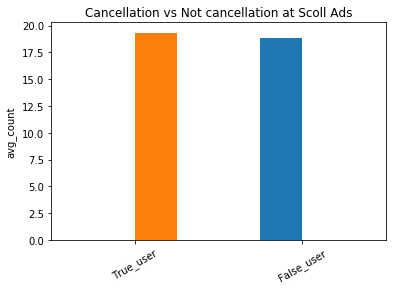

In [25]:
#用柱形图对比注销用户和非注销用户的人均点击广告量，True_user为注销用户，False_user为非注销用户
avg_count.plot.bar(title='Cancellation vs Not cancellation at Scoll Ads', legend=False, rot=30)
plt.ylabel('avg_count');


可以看出注销用户人均点击广告量要比非注销用户高一些，广告点击量可以放在特征里。

In [26]:
#分别找出注销用户和非注销用户平均每个人的听歌量然后合并到一张数据框上
avg_count_true_songs_played = data.filter("page == 'NextSong' AND Churn == 1").groupby(data.userId).count().agg(avg('count').alias('avg_count_true'))
avg_count_true_songs_played = avg_count_true_songs_played.toPandas()
avg_count_false_songs_played = data.filter("page == 'NextSong' AND Churn == 0").groupby(data.userId).count().agg(avg('count').alias('avg_count_false'))
avg_count_false_songs_played = avg_count_false_songs_played.toPandas()
avg_count_songs = pd.concat([avg_count_true_songs_played, avg_count_false_songs_played], axis=0, ignore_index=True, sort=False)
avg_count_songs.index = ['True_user', 'False_user']
avg_count

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,avg_count_false,avg_count_true
True_user,NaN,19.34
False_user,18.89172,NaN


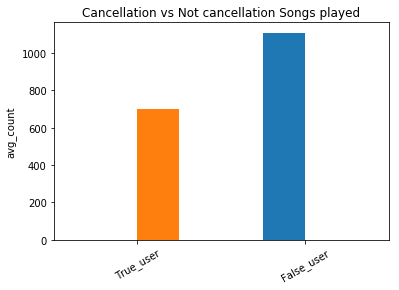

In [27]:
#用柱形图对比注销用户和非注销用户的人均听歌量，True_user为注销用户，False_user为非注销用户
avg_count_songs.plot.bar(title='Cancellation vs Not cancellation Songs played', legend=False, rot=30)
plt.ylabel('avg_count');

可以看出注销用户人均听歌量要比非注销用户少很多，听歌量可以放在特征里。

In [28]:
data.filter(data.page == 'Help').take(1)

[Row(artist=None, auth='Logged In', firstName='Alex', gender='M', itemInSession=7, lastName='Hogan', length=None, level='free', location='Denver-Aurora-Lakewood, CO', method='GET', page='Help', registration=1535066380000, sessionId=100, song=None, status=200, ts=1538359923000, userAgent='Mozilla/5.0 (Windows NT 6.2; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='101', Churn=1)]

In [29]:
#分别找出注销用户和非注销用户平均每个人的帮助页面点击量，然后合并到一张数据框上
avg_count_true_help = data.filter("page == 'Help' AND Churn == 1").groupby(data.userId).count().agg(avg('count').alias('avg_count_true'))
avg_count_true_help = avg_count_true_help.toPandas()
avg_count_false_help = data.filter("page == 'Help' AND Churn == 0").groupby(data.userId).count().agg(avg('count').alias('avg_count_false'))
avg_count_false_help = avg_count_false_help.toPandas()
avg_count_help = pd.concat([avg_count_true_help, avg_count_false_help], axis=0, ignore_index=True, sort=False)
avg_count_help.index = ['True_user', 'False_user']
avg_count_help

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,avg_count_false,avg_count_true
True_user,NaN,5.55814
False_user,8.154362,NaN


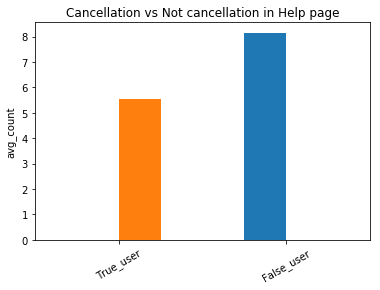

In [30]:
#用柱形图对比注销用户和非注销用户的人均帮助页面点击量，True_user为注销用户，False_user为非注销用户
avg_count_help.plot.bar(title='Cancellation vs Not cancellation in Help page', legend=False, rot=30)
plt.ylabel('avg_count');

可以看到，注销用户人均点击帮助页面量要比非注销用户低，帮助页面点击量可以放在特征里。

In [31]:
#可视化在注销用户与非注销用户里面的性别数量对比
gender = data.dropDuplicates(['userId']).groupby(['Churn', 'gender']).count()
gender = gender.toPandas()
gender.Churn = gender.Churn.replace([1, 0], ['True', 'False'])
gender_1 = pd.DataFrame(pd.pivot_table(gender, index='Churn', columns='gender', values='count'))

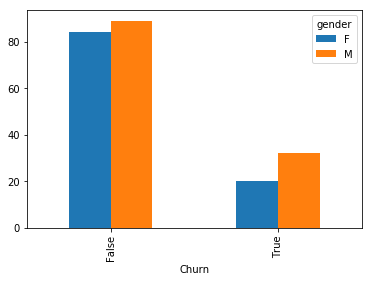

In [32]:
gender_1.plot.bar();

可以看到，注销用户里男性要相对多一些，性别可以放到特征里。

In [33]:
#可视化在注销用户与非注销用户里面的用户类型数量对比
level = data.dropDuplicates(['userId']).groupby(['Churn', 'level']).count()
level = level.toPandas()
level.Churn = level.Churn.replace([1, 0], ['True', 'False'])
level_1 = pd.DataFrame(pd.pivot_table(level, index='Churn', columns='level', values='count'))

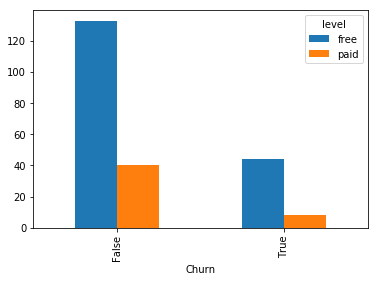

In [34]:
level_1.plot.bar();

可以看到在注销用户里付费用户相对少一些，level可以放在特征里。

# 特征工程
熟悉了数据之后，就可以构建你认为会对训练模型帮助最大的特征。要处理完整数据集，你可以按照下述步骤：
- 写一个脚本来从小数据集中提取你需要的特征
- 确保你的脚本可以拓展到大数据集上，使用之前教过的最佳实践原则
- 在完整数据集上运行你的脚本，按运行情况调试代码

如果是在教室的 workspace，你可以直接用里面提供的小数据集来提取特征。确保当你开始使用 Spark 集群的时候，把上述的成果迁移到大数据集上。

In [35]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Churn: integer (nullable = true)



In [36]:
#把gender和level转化为数值,gender:(F:0, M:1), level:(free:0,paid:1)
data = data.replace(['F', 'M'], ['0', '1'], 'gender')
data = data.replace(['free', 'paid'], ['0', '1'], 'level')
data = data.withColumn('gender', data.gender.cast('int'))
data = data.withColumn('level', data.level.cast('int'))

In [37]:
data.select(['gender']).dropDuplicates().show()

+------+
|gender|
+------+
|     1|
|     0|
+------+



In [38]:
data.select(['level']).dropDuplicates().show()

+-----+
|level|
+-----+
|    1|
|    0|
+-----+



In [39]:
#添加特征Help，计算每个用户点了多少个Help页面
data_help = data.filter(data.page == 'Help').groupby('userId').agg(count('page').alias('Help')).select(['userId', 'Help'])
data = data.join(data_help, 'userId')

In [40]:
#添加特征Songs，计算每个用户听了多少首歌
data_songs = data.filter(data.page == 'NextSong').groupby('userId').agg(count('page').alias('Songs')).select(['userId', 'Songs'])
data = data.join(data_songs, 'userId')

In [41]:
#添加特征列Ads，计算每个用户点击了多少个广告
data_ads = data.filter(data.page == 'Roll Advert').groupby('userId').agg(count('page').alias('Ads')).select(['userId', 'Ads'])
data = data.join(data_ads, 'userId')

In [42]:
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- Help: long (nullable = false)
 |-- Songs: long (nullable = false)
 |-- Ads: long (nullable = false)



In [43]:
data.take(3)

[Row(userId='100010', artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender=0, itemInSession=0, lastName='Carpenter', length=202.97098, level=0, location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', Churn=0, Help=2, Songs=275, Ads=52),
 Row(userId='100010', artist='Francesca Battistelli', auth='Logged In', firstName='Darianna', gender=0, itemInSession=1, lastName='Carpenter', length=196.54485, level=0, location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Beautiful_ Beautiful (Album)', status=200, ts=1539003736000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (

In [44]:
#创建训练模型使用的数据集
data_model = data.select(['userId', 'Ads', 'Songs', 'Help', 'level', 'gender', 'Churn'])

In [45]:
data_model.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Ads: long (nullable = false)
 |-- Songs: long (nullable = false)
 |-- Help: long (nullable = false)
 |-- level: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- Churn: integer (nullable = true)



In [46]:
data_model.take(3)

[Row(userId='100010', Ads=52, Songs=275, Help=2, level=0, gender=0, Churn=0),
 Row(userId='100010', Ads=52, Songs=275, Help=2, level=0, gender=0, Churn=0),
 Row(userId='100010', Ads=52, Songs=275, Help=2, level=0, gender=0, Churn=0)]

# 建模
将完整数据集分成训练集、测试集和验证集。测试几种你学过的机器学习方法。评价不同机器学习方法的准确率，根据情况调节参数。根据准确率你挑选出表现最好的那个模型，然后报告在训练集上的结果。因为流失顾客数据集很小，我建议选用 F1 score 作为优化指标。

### 逻辑回归

In [47]:
#把数据集分成训练集和测试集
#因为运行模型太耗时间了在完成这一部分后我才意识到要加上给每个步骤加上seed，所以seed都是得出结果后才加上去的
train, test = data_model.randomSplit([0.7, 0.3], seed=20)

In [48]:
#搭建数据管道
assembler = VectorAssembler(inputCols=data_model.columns[1:6], outputCol='FeaturesVector')
scaler = StandardScaler(inputCol='FeaturesVector', outputCol='features', withStd=True, withMean=True)
indexer = StringIndexer(inputCol='Churn', outputCol='label')
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pipeline = Pipeline(stages=[assembler, scaler, indexer, lr])

In [49]:
#设置参数
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.0, 0.2]) \
    .addGrid(lr.maxIter, [10, 20]) \
    .addGrid(lr.threshold, [0.44, 0.46]) \
    .build()

#设置交叉验证
crossval_lr = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [50]:
#用训练集训练模型
model_lr = crossval_lr.fit(train)
model_lr.avgMetrics

[0.7839428779086828,
 0.7811609093671757,
 0.7831739569490797,
 0.7801443978024513,
 0.7711953383581067,
 0.7711953383581067,
 0.7711953383581067,
 0.7711953383581067]

In [51]:
#在测试集上测试模型
results_lr = model_lr.transform(test)

In [52]:
#得出F1分数
MulticlassClassificationEvaluator(metricName='f1').evaluate(results_lr)

0.7840683558206027

In [53]:
results_lr.select('prediction').dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

第一次预测参数只有regParam, 结果标签全部为0。第二次我增加了太多的参数导致太慢了, 所以减少了一些，但是结果还是都为0。第三次我觉得可能是threshold值有问题，默认为0.5， 我把它调低了一些试了一下，但是调整的太低了导致结果过拟合，最后调整到合适的参数后结果较好。

### GBT分类器

In [54]:
#搭建数据管道
gbt = GBTClassifier(maxIter=10, seed=25)
pipeline = Pipeline(stages=[assembler, scaler, indexer, gbt])

In [61]:
#设置参数
paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [1, 3]) \
    .addGrid(gbt.maxIter, [1, 3]) \
    .build()

#设置交叉验证
crossval_gbt = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [62]:
#用训练集训练模型
model_gbt = crossval_gbt.fit(train)

In [63]:
model_gbt.avgMetrics

[0.7711953383581067, 0.7711953383581067, 0.7904130319414593, 0.816105468440852]

In [64]:
#在测试集上测试模型
results_gbt = model_gbt.transform(test)

In [65]:
#得出F1分数
MulticlassClassificationEvaluator(metricName='f1').evaluate(results_gbt)

0.8040928006815921

In [66]:
results_gbt.select('prediction').dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

刚开始参数太多导致运行太慢，减少参数并把参数减小后速度提升。

### 随机森林分类器

In [67]:
#搭建数据管道
rf = RandomForestClassifier(numTrees=5, maxDepth=3, seed=30)
pipeline = Pipeline(stages=[assembler, scaler, indexer, rf])

In [80]:
#设置参数
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [5, 10]) \
    .addGrid(rf.minInstancesPerNode, [1, 3]) \
    .addGrid(rf.maxDepth, [3, 7]) \
    .addGrid(rf.minInfoGain, [0, 1]) \
    .build()

#设置交叉验证
crossval_rf = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

In [81]:
#用训练集训练模型
model_rf = crossval_rf.fit(train)

In [82]:
model_rf.avgMetrics

[0.7711953383581067,
 0.7711953383581067,
 0.9324035552650634,
 0.7711953383581067,
 0.7711953383581067,
 0.7711953383581067,
 0.9324035552650634,
 0.7711953383581067,
 0.7810091502462548,
 0.7711953383581067,
 0.9369820485756835,
 0.7711953383581067,
 0.7810091502462548,
 0.7711953383581067,
 0.9369820485756835,
 0.7711953383581067]

In [83]:
#在测试集上测试模型
results_rf = model_rf.transform(test)

In [84]:
#得出F1分数
MulticlassClassificationEvaluator(metricName='f1').evaluate(results_rf)

0.9342054807211727

In [85]:
results_rf.select('prediction').dropDuplicates().collect()

[Row(prediction=0.0), Row(prediction=1.0)]

In [89]:
result_rf = results_rf.select(['label', 'prediction']).toPandas()

In [93]:
result_rf.count()

label         78780
prediction    78780
dtype: int64

In [92]:
result_rf[result_rf['label'] == result_rf['prediction']].count()

label         74073
prediction    74073
dtype: int64

第一次添加了太多参数分别是numTrees, minInstancesPerNode，maxDepth，minInfoGain，并且参数量很大，导致模型运行的太慢了。然后我取消了一个minInfoGain参数，但是第二次的结果标签全部为0，因此我把参数名字调整的和第一次一样，但是把minInfoGain调整小分别为0和1，minInstancesPerNode分别调整小为1和3，我把numTrees和maxDepth分别调小来让模型运行速度提升，结果还不错。
最好的参数为：
numTrees:10
minInstancesPerNode:1
maxDepth:7
minInfoGain:0.0

### 模型对比
最好的F1分数对比

LogisticRegression：（F1 Score：0.7840683558206027）

GBTClassifier：（F1 Score：0.8040928006815921）

RandomForestClassifier：（F1 Score：0.9342054807211727）


In [99]:
metric = model_rf.avgMetrics
best_index = metric.index(max(metric))
best_param = model_rf.getEstimatorParamMaps()[best_index]
print('效果最好模型是随机森林分类器模型，最好的参数为：')
for name, score in best_param.items():
    print('{}:{}'.format(name.name, score))

效果最好模型是随机森林分类器模型，最好的参数为：
numTrees:10
minInstancesPerNode:1
maxDepth:7
minInfoGain:0.0


### 结果讨论
本项目中的问题是预测流失用户，也就是一个二元分类预测问题，所以所选择的模型要契合这一特点效果会比较好，我用了随机森林分类器，GBT分类器和逻辑回归分类器，效果最好的是随机森林分类器，F1分数达到了非常高的0.93，首先我对数据集进行了清洗，然后用EDA方法对数据集进行了探索，找出特征之间的规律，对需要的特征进行特征工程，最后建立机器学习模型对其预测。随机森林分类器专门用来解决分类和回归问题，而且可以同时处理分类和数值特征并且抗过拟合能力较强，我想这也是在训练集和测试集都表现良好的体现。但是由于项目提供的数据集较少，因为网络问题无法使用IBMCloud等处理大数据强大工具，在本机上运行模型收到硬件和网络的限制，调整参数变得更加困难，如果这些方面可以提升，我觉得结果会更好。

### 困难与挑战

在最后建立模型的时候有很多模型可以用，但是经过我测试了很多模型发现，有的模型会出现难以解决的错误，比如说我在使用NaiveBayes模型的时候就出现了复杂的错误，在网上很难找到解决方案，与软件版本号有关，这时候就要换一个模型。还有在调整参数的时候刚开始输入了不合适的参数导致效果非常慢，后来在网上对每个参数进行搜索和深度了解后优化参数，这一步比较难，因为牵扯到时间成本。还有在可视化的时候我需要把一个pandas数据框的列转换成行然后直接转化成我要的柱状图，我试了一些方法都没有成功，直到在网上查到了melt和pivot混合使用方法才解决。

### 有趣的发现

在我用柱形图对比注销用户和非注销用户的人均帮助页面点击量时我发现了有意思的事情，结果显示注销用户的人均帮助点击量要比非注销用户的少很多，我的主观意识一开始告诉我，点击帮助页面越少应该代表遇到使用问题越少导致软件使用体验越好才对，那为什么流失用户点击量要比留存用户少呢？我仔细想了想，可能是流失用户遇到软件使用困难的时候软件没有给到有效的帮助指引，或者是用户看不懂，也有可能是用户不知道去哪里找帮助页面造成的，而不是真的没有遇到使用问题。

### 反思与改进
在进行特征工程的时候我把gender和level两个特征分别转化为0和1，但是我忘记把它们转化为整数类型了，从而导致了在建立模型的时候有类型错误，所以在处理特征的时候一定要特别注意数据类型的转换。在建模的时候我选择了很多模型，其中有几个因为出现了比较难解决的错误，包括牵扯到一些软件版本问题，我只能重新筛选模型，对比，找到最适合的几个。由于我没有使用IBM Cloud和AWS，所以在调参的时候刚开始经历了很多次运行漫长的经历，后来通过调整合适的参数，减少参数来解决这一问题，在运行模型的时候不光要考虑效果也要考虑效率，综合硬件和环境能来用最快的时间建立最优的模型。

# 最后一步
清理你的代码，添加注释和重命名变量，使得代码更易读和易于维护。参考 Spark 项目概述页面和数据科学家毕业项目审阅要求，确保你的项目包含了毕业项目要求的所有内容，并且满足所有审阅要求。记得在 GitHub 代码库里包含一份全面的文档——README文件，以及一个网络应用程序或博客文章。